# Advanced Geospatial Analysis of MODIS Vegetation Indices

**Objective:** This notebook conducts an in-depth exploratory data analysis (EDA) of pre-processed MODIS vegetation data. We will create insightful maps, animations, and time-series plots to reveal patterns in vegetation health across the Santiago Canyon study area, enhanced with key geographical reference points for better orientation.

**Requirements:** 
- `data/scripts/download_modis_data.py` downloads raw MODIS data (h08v05 tile, MOD13Q1 product)
- `data/scripts/modis_processor.py` processes HDF files to GeoTIFF format in `data/processed/geotiff_evi` and `data/processed/geotiff_ndvi`
- This notebook analyzes the processed GeoTIFF files

## Understanding NDVI and EVI

This analysis uses two key vegetation indices provided by MODIS:

1. **NDVI (Normalized Difference Vegetation Index):** Most common index for assessing vegetation greenness
   - **Strengths:** Excellent for general vegetation health monitoring
   - **Weaknesses:** Can saturate in very dense vegetation areas

2. **EVI (Enhanced Vegetation Index):** Optimized for high biomass areas
   - **Strengths:** Better performance in dense vegetation, less atmospheric interference
   - **Weaknesses:** More sensitive to topographic effects

**Why use both?** Comparing NDVI and EVI provides a more nuanced understanding of vegetation dynamics.

## 1. Setup and Library Imports

In [3]:
# Core libraries
import os
import glob
import warnings
from datetime import datetime
import numpy as np
import pandas as pd

# Geospatial libraries
import rioxarray
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Data paths
NDVI_DIR = '../../data/processed/geotiff_ndvi/'
EVI_DIR = '../../data/processed/geotiff_evi/'
GEOJSON_PATH = '../../data/santiago.geojson'

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [4]:
# Find all available files
ndvi_files = sorted(glob.glob(os.path.join(NDVI_DIR, '*.tif')))
evi_files = sorted(glob.glob(os.path.join(EVI_DIR, '*.tif')))

print(f"📊 Data Discovery:")
print(f"   • NDVI files found: {len(ndvi_files)}")
print(f"   • EVI files found: {len(evi_files)}")
print(f"   • Data directories exist: {os.path.exists(NDVI_DIR) and os.path.exists(EVI_DIR)}")

if len(ndvi_files) == 0 or len(evi_files) == 0:
    print("❌ No data files found. Please run the data processing scripts first.")
else:
    print("✅ Data files found successfully")
    
    # Sample a few filenames to understand the naming convention
    print(f"\n📋 Sample filenames:")
    for i, file in enumerate(ndvi_files[:3]):
        print(f"   {i+1}. {os.path.basename(file)}")


📊 Data Discovery:
   • NDVI files found: 587
   • EVI files found: 587
   • Data directories exist: True
✅ Data files found successfully

📋 Sample filenames:
   1. MOD13Q1.A2000049.h08v05.061.2020041152304_NDVI.tif
   2. MOD13Q1.A2000065.h08v05.061.2020040135924_NDVI.tif
   3. MOD13Q1.A2000081.h08v05.061.2020041144706_NDVI.tif


In [5]:
# Define key reference points for geographical context
reference_points = {
    'Santiago Peak': (33.745, -117.533),
    'Long Beach': (33.770, -118.194),
    'UC Irvine': (33.640, -117.844),
    'Lake Mathews': (33.857, -117.424)
}

# Create GeoDataFrame for reference points
points_gdf = gpd.GeoDataFrame(
    {
        'name': list(reference_points.keys()),
        'geometry': [Point(lon, lat) for lat, lon in reference_points.values()]
    },
    crs='EPSG:4326'
)

print("🗺️ Reference Points Created:")
print(points_gdf)
print(f"\n📍 Coordinate Reference System: {points_gdf.crs}")


🗺️ Reference Points Created:
            name                 geometry
0  Santiago Peak  POINT (-117.533 33.745)
1     Long Beach   POINT (-118.194 33.77)
2      UC Irvine   POINT (-117.844 33.64)
3   Lake Mathews  POINT (-117.424 33.857)

📍 Coordinate Reference System: EPSG:4326


In [6]:
def extract_date_from_filename(filename):
    """
    Extract date from MODIS filename format: MOD13Q1.AYYYYDDD.*.tif
    where YYYY is year and DDD is day of year
    """
    try:
        basename = os.path.basename(filename)
        date_part = basename.split('.')[1][1:8]  # Extract YYYYDDD
        return datetime.strptime(date_part, '%Y%j')
    except Exception as e:
        print(f"⚠️ Error parsing date from {filename}: {e}")
        return None

def create_vegetation_cube(file_list, index_name):
    """
    Create a spatio-temporal data cube from GeoTIFF files
    """
    print(f"📦 Creating {index_name} data cube...")
    
    # Extract dates and create time coordinates
    dates = [extract_date_from_filename(f) for f in file_list]
    valid_files_dates = [(f, d) for f, d in zip(file_list, dates) if d is not None]
    
    if not valid_files_dates:
        raise ValueError(f"No valid files found for {index_name}")
    
    files, time_coords = zip(*valid_files_dates)
    
    # Load and concatenate raster data
    try:
        data_arrays = []
        for file in files:
            da = rioxarray.open_rasterio(file).squeeze()
            # Remove band dimension if present
            if 'band' in da.dims:
                da = da.isel(band=0)
            data_arrays.append(da)
        
        # Create data cube
        data_cube = xr.concat(data_arrays, dim=pd.Index(time_coords, name='time'))
        
        # Handle duplicate timestamps by averaging
        if data_cube.indexes['time'].has_duplicates:
            print(f"   ⚠️ Found duplicate timestamps, averaging values...")
            data_cube = data_cube.groupby('time').mean()
        
        # Reproject to WGS84 for consistency
        if data_cube.rio.crs != 'EPSG:4326':
            print(f"   🌍 Reprojecting to WGS84...")
            data_cube = data_cube.rio.reproject('EPSG:4326')
        
        print(f"   ✅ {index_name} cube created: {data_cube.dims} - {len(data_cube.time)} time steps")
        return data_cube
        
    except Exception as e:
        print(f"   ❌ Error creating {index_name} cube: {e}")
        raise

def calculate_basic_stats(data_cube, name):
    """
    Calculate basic statistics for a data cube
    """
    stats = {
        'mean': float(data_cube.mean().values),
        'std': float(data_cube.std().values),
        'min': float(data_cube.min().values),
        'max': float(data_cube.max().values),
        'median': float(data_cube.median().values)
    }
    
    print(f"\n📈 {name} Statistics:")
    for key, value in stats.items():
        print(f"   • {key.capitalize()}: {value:.4f}")
    
    return stats

print("🔧 Data processing functions defined")


🔧 Data processing functions defined


In [7]:
# Create data cubes for both indices
if len(ndvi_files) > 0 and len(evi_files) > 0:
    ndvi_cube = create_vegetation_cube(ndvi_files, "NDVI")
    evi_cube = create_vegetation_cube(evi_files, "EVI")
    
    # Calculate basic statistics
    ndvi_stats = calculate_basic_stats(ndvi_cube, "NDVI")
    evi_stats = calculate_basic_stats(evi_cube, "EVI")
    
    # Display temporal coverage
    print(f"\n📅 Temporal Coverage:")
    print(f"   • NDVI: {ndvi_cube.time.min().values} to {ndvi_cube.time.max().values}")
    print(f"   • EVI:  {evi_cube.time.min().values} to {evi_cube.time.max().values}")
    
    # Display spatial coverage
    print(f"\n🗺️ Spatial Coverage:")
    print(f"   • Latitude range: {float(ndvi_cube.y.min()):.3f}° to {float(ndvi_cube.y.max()):.3f}°")
    print(f"   • Longitude range: {float(ndvi_cube.x.min()):.3f}° to {float(ndvi_cube.x.max()):.3f}°")
    print(f"   • Spatial resolution: {len(ndvi_cube.y)} x {len(ndvi_cube.x)} pixels")
    
else:
    print("❌ Cannot create data cubes - no files found")


📦 Creating NDVI data cube...
   ⚠️ Found duplicate timestamps, averaging values...
   🌍 Reprojecting to WGS84...
   ✅ NDVI cube created: ('time', 'y', 'x') - 584 time steps
📦 Creating EVI data cube...
   ⚠️ Found duplicate timestamps, averaging values...
   🌍 Reprojecting to WGS84...
   ✅ EVI cube created: ('time', 'y', 'x') - 584 time steps

📈 NDVI Statistics:
   • Mean: 0.3888
   • Std: 0.1490
   • Min: -0.2000
   • Max: 0.9995
   • Median: 0.3658

📈 EVI Statistics:
   • Mean: 0.2106
   • Std: 0.0889
   • Min: -0.0850
   • Max: 1.0000
   • Median: 0.1946

📅 Temporal Coverage:
   • NDVI: 2000-02-18T00:00:00.000000000 to 2025-06-26T00:00:00.000000000
   • EVI:  2000-02-18T00:00:00.000000000 to 2025-06-26T00:00:00.000000000

🗺️ Spatial Coverage:
   • Latitude range: 33.092° to 34.136°
   • Longitude range: -118.961° to -115.821°
   • Spatial resolution: 269 x 807 pixels


## 6. Data Quality Assessment

🔍 Data Quality Assessment:
   • NDVI missing values: 103,717,585 (81.81%)
   • EVI missing values: 103,717,585 (81.81%)
   • NDVI values in expected range [-1, 1]: ❌
   • EVI values in expected range [-1, 1]: ❌
   • NDVI and EVI have same temporal coverage: ✅


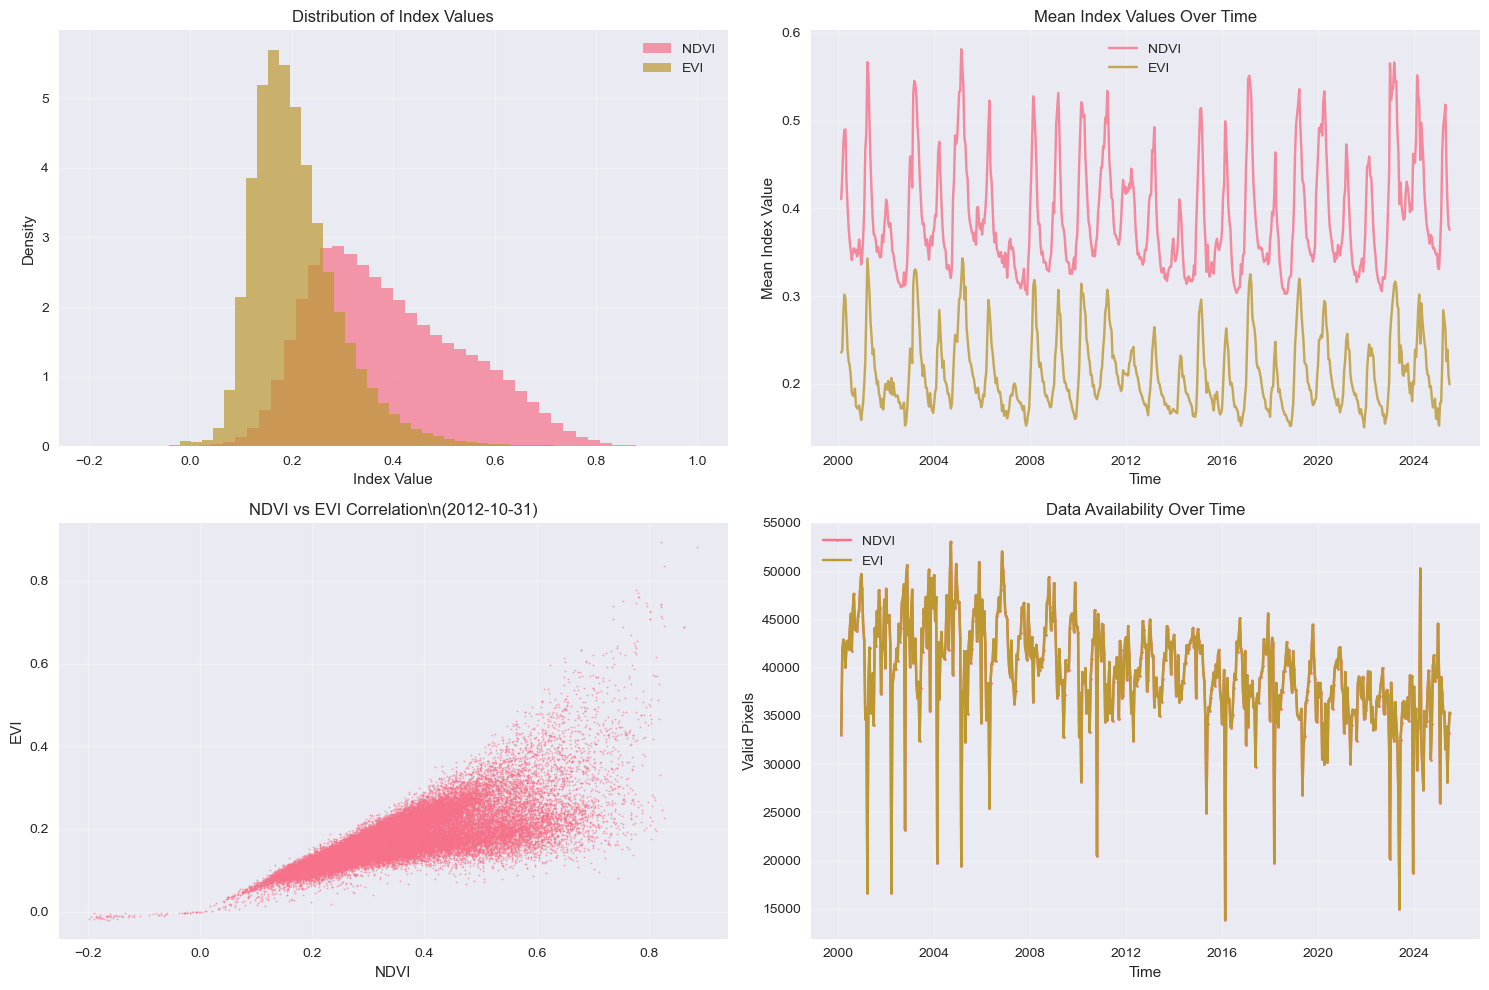

\n✅ Data quality assessment completed


In [8]:
if 'ndvi_cube' in locals() and 'evi_cube' in locals():
    # Check for missing data
    ndvi_missing = np.isnan(ndvi_cube).sum().values
    evi_missing = np.isnan(evi_cube).sum().values
    total_pixels = ndvi_cube.size
    
    print(f"🔍 Data Quality Assessment:")
    print(f"   • NDVI missing values: {ndvi_missing:,} ({100*ndvi_missing/total_pixels:.2f}%)")
    print(f"   • EVI missing values: {evi_missing:,} ({100*evi_missing/total_pixels:.2f}%)")
    
    # Check value ranges (NDVI should be -1 to 1, EVI typically 0 to 1)
    ndvi_range_ok = (ndvi_cube >= -1).all() and (ndvi_cube <= 1).all()
    evi_range_ok = (evi_cube >= -1).all() and (evi_cube <= 1).all()
    
    print(f"   • NDVI values in expected range [-1, 1]: {'✅' if ndvi_range_ok else '❌'}")
    print(f"   • EVI values in expected range [-1, 1]: {'✅' if evi_range_ok else '❌'}")
    
    # Temporal consistency check
    time_diff = len(ndvi_cube.time) == len(evi_cube.time)
    print(f"   • NDVI and EVI have same temporal coverage: {'✅' if time_diff else '❌'}")
    
    # Create quality summary plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram of values
    ndvi_flat = ndvi_cube.values.flatten()
    evi_flat = evi_cube.values.flatten()
    ndvi_valid = ndvi_flat[~np.isnan(ndvi_flat)]
    evi_valid = evi_flat[~np.isnan(evi_flat)]
    
    axes[0, 0].hist(ndvi_valid, bins=50, alpha=0.7, label='NDVI', density=True)
    axes[0, 0].hist(evi_valid, bins=50, alpha=0.7, label='EVI', density=True)
    axes[0, 0].set_xlabel('Index Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Distribution of Index Values')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Time series of mean values
    mean_ndvi_ts = ndvi_cube.mean(dim=['x', 'y'])
    mean_evi_ts = evi_cube.mean(dim=['x', 'y'])
    
    axes[0, 1].plot(mean_ndvi_ts.time, mean_ndvi_ts.values, label='NDVI', alpha=0.8)
    axes[0, 1].plot(mean_evi_ts.time, mean_evi_ts.values, label='EVI', alpha=0.8)
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Mean Index Value')
    axes[0, 1].set_title('Mean Index Values Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Scatter plot NDVI vs EVI (sample)
    sample_date = ndvi_cube.time[len(ndvi_cube.time)//2]
    ndvi_sample = ndvi_cube.sel(time=sample_date, method='nearest')
    evi_sample = evi_cube.sel(time=sample_date, method='nearest')
    
    valid_mask = ~(np.isnan(ndvi_sample.values) | np.isnan(evi_sample.values))
    axes[1, 0].scatter(ndvi_sample.values[valid_mask], evi_sample.values[valid_mask], 
                       alpha=0.5, s=1)
    axes[1, 0].set_xlabel('NDVI')
    axes[1, 0].set_ylabel('EVI')
    axes[1, 0].set_title(f'NDVI vs EVI Correlation\\n({str(sample_date.values)[:10]})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Data availability heatmap
    ndvi_availability = (~np.isnan(ndvi_cube)).sum(dim=['x', 'y'])
    evi_availability = (~np.isnan(evi_cube)).sum(dim=['x', 'y'])
    
    axes[1, 1].plot(ndvi_availability.time, ndvi_availability.values, label='NDVI', marker='o', markersize=2)
    axes[1, 1].plot(evi_availability.time, evi_availability.values, label='EVI', marker='s', markersize=2)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Valid Pixels')
    axes[1, 1].set_title('Data Availability Over Time')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\\n✅ Data quality assessment completed")
else:
    print("❌ Cannot perform quality assessment - data cubes not available")

## 7. Spatial Visualization

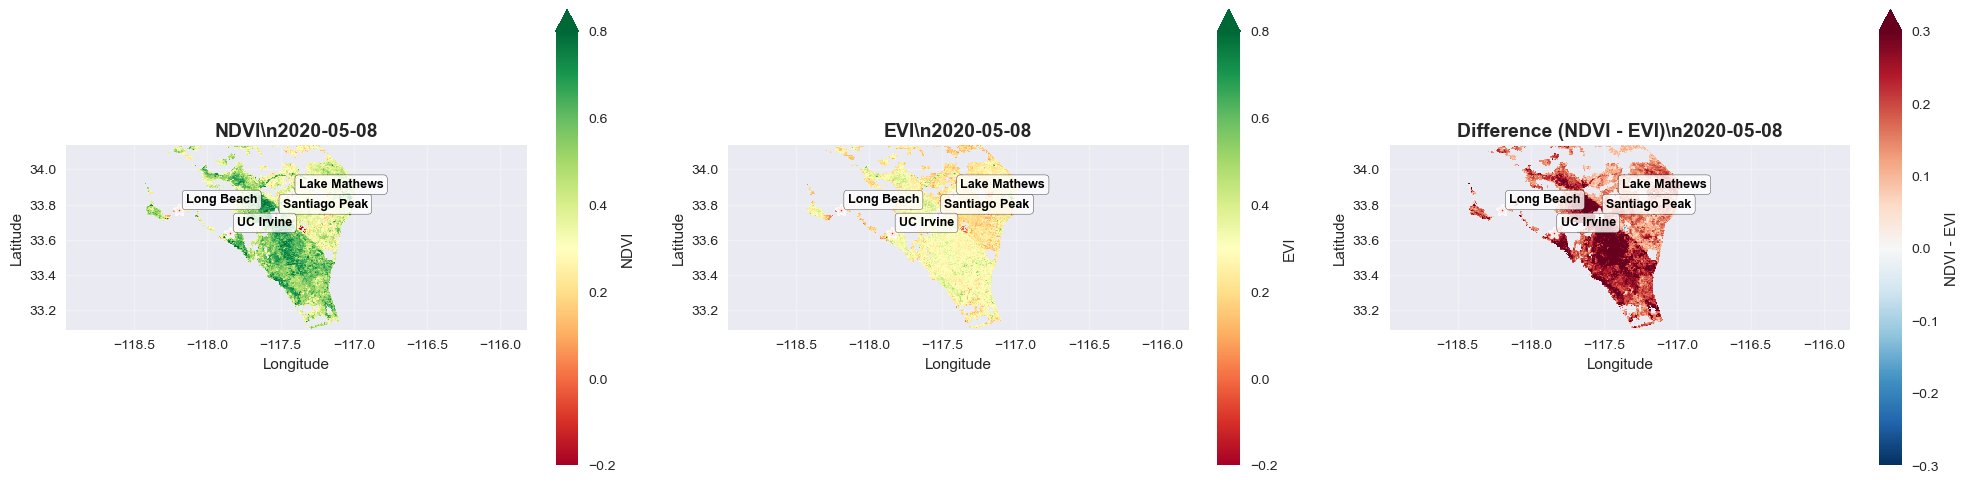

🗺️ Spatial Analysis for 2020-05-08:
   • NDVI: Mean=0.463, Std=0.148
   • EVI:  Mean=0.267, Std=0.082
   • Spatial correlation: 0.882


In [9]:
if 'ndvi_cube' in locals() and 'evi_cube' in locals():
    # Select a representative date for spatial visualization
    sample_date = '2020-05-01'  # Spring date for good vegetation
    
    try:
        ndvi_sample = ndvi_cube.sel(time=sample_date, method='nearest')
        evi_sample = evi_cube.sel(time=sample_date, method='nearest')
        actual_date = str(ndvi_sample.time.values)[:10]
        
        # Create enhanced spatial visualization
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        # NDVI map
        im1 = ndvi_sample.plot(ax=axes[0], cmap='RdYlGn', vmin=-0.2, vmax=0.8, 
                               add_colorbar=True, cbar_kwargs={'label': 'NDVI', 'shrink': 0.8})
        axes[0].set_title(f'NDVI\\n{actual_date}', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        
        # EVI map
        im2 = evi_sample.plot(ax=axes[1], cmap='RdYlGn', vmin=-0.2, vmax=0.8,
                              add_colorbar=True, cbar_kwargs={'label': 'EVI', 'shrink': 0.8})
        axes[1].set_title(f'EVI\\n{actual_date}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        
        # Difference map (NDVI - EVI)
        diff_map = ndvi_sample - evi_sample
        im3 = diff_map.plot(ax=axes[2], cmap='RdBu_r', vmin=-0.3, vmax=0.3,
                            add_colorbar=True, cbar_kwargs={'label': 'NDVI - EVI', 'shrink': 0.8})
        axes[2].set_title(f'Difference (NDVI - EVI)\\n{actual_date}', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        
        # Add reference points to all maps
        for ax in axes:
            points_gdf.plot(ax=ax, color='red', markersize=60, alpha=0.9, 
                           edgecolor='white', linewidth=2, marker='*')
            
            # Add point labels
            for idx, row in points_gdf.iterrows():
                ax.annotate(row['name'], (row.geometry.x, row.geometry.y), 
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=9, fontweight='bold', color='black',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print spatial statistics
        print(f"🗺️ Spatial Analysis for {actual_date}:")
        print(f"   • NDVI: Mean={float(ndvi_sample.mean()):.3f}, Std={float(ndvi_sample.std()):.3f}")
        print(f"   • EVI:  Mean={float(evi_sample.mean()):.3f}, Std={float(evi_sample.std()):.3f}")
        
        # Calculate correlation
        valid_mask = ~(np.isnan(ndvi_sample.values) | np.isnan(evi_sample.values))
        if valid_mask.sum() > 0:
            correlation = np.corrcoef(ndvi_sample.values[valid_mask], 
                                    evi_sample.values[valid_mask])[0, 1]
            print(f"   • Spatial correlation: {correlation:.3f}")
        
    except Exception as e:
        print(f"❌ Error creating spatial visualization: {e}")
        print("Available time range:", ndvi_cube.time.min().values, "to", ndvi_cube.time.max().values)
else:
    print("❌ Cannot create spatial visualization - data cubes not available")

## 8. Temporal Analysis

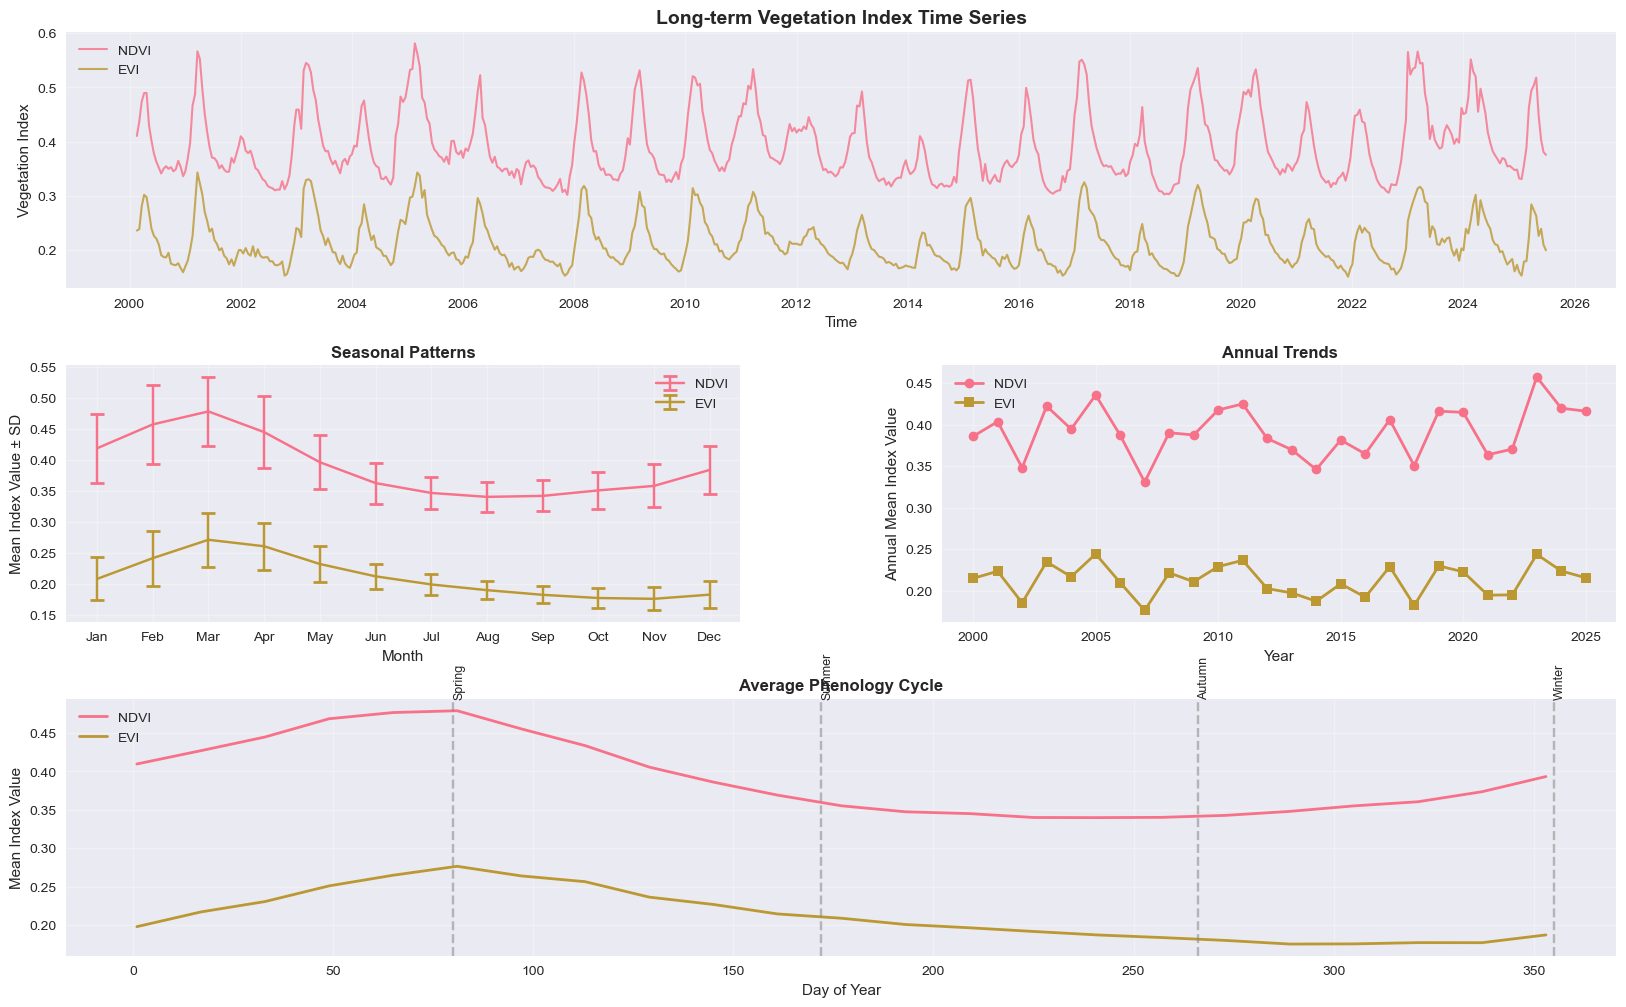

📈 Temporal Analysis Summary:
   • Time period: 2000-02-18 to 2025-06-26
   • Total observations: 584
   • Years covered: 26


TypeError: list indices must be integers or slices, not Series

In [10]:
if 'ndvi_cube' in locals() and 'evi_cube' in locals():
    # Calculate mean time series
    ndvi_ts = ndvi_cube.mean(dim=['x', 'y']).to_dataframe(name='NDVI').reset_index()
    evi_ts = evi_cube.mean(dim=['x', 'y']).to_dataframe(name='EVI').reset_index()
    
    # Merge time series
    ts_data = pd.merge(ndvi_ts, evi_ts, on='time', how='outer')
    ts_data['year'] = ts_data['time'].dt.year
    ts_data['month'] = ts_data['time'].dt.month
    ts_data['doy'] = ts_data['time'].dt.dayofyear
    
    # Create comprehensive temporal analysis
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Full time series
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(ts_data['time'], ts_data['NDVI'], label='NDVI', alpha=0.8, linewidth=1.5)
    ax1.plot(ts_data['time'], ts_data['EVI'], label='EVI', alpha=0.8, linewidth=1.5)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Vegetation Index')
    ax1.set_title('Long-term Vegetation Index Time Series', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis for better readability
    ax1.xaxis.set_major_locator(mdates.YearLocator(2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_minor_locator(mdates.YearLocator())
    
    # 2. Seasonal patterns (by month)
    ax2 = fig.add_subplot(gs[1, 0])
    monthly_stats = ts_data.groupby('month')[['NDVI', 'EVI']].agg(['mean', 'std']).reset_index()
    
    months = monthly_stats['month']
    ax2.errorbar(months, monthly_stats[('NDVI', 'mean')], 
                yerr=monthly_stats[('NDVI', 'std')], label='NDVI', capsize=5, capthick=2)
    ax2.errorbar(months, monthly_stats[('EVI', 'mean')], 
                yerr=monthly_stats[('EVI', 'std')], label='EVI', capsize=5, capthick=2)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Mean Index Value ± SD')
    ax2.set_title('Seasonal Patterns', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Annual trends
    ax3 = fig.add_subplot(gs[1, 1])
    annual_stats = ts_data.groupby('year')[['NDVI', 'EVI']].mean().reset_index()
    
    ax3.plot(annual_stats['year'], annual_stats['NDVI'], marker='o', label='NDVI', linewidth=2)
    ax3.plot(annual_stats['year'], annual_stats['EVI'], marker='s', label='EVI', linewidth=2)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Annual Mean Index Value')
    ax3.set_title('Annual Trends', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Phenology analysis (day of year patterns)
    ax4 = fig.add_subplot(gs[2, :])
    
    # Calculate rolling mean for smoother phenology curves
    phenology_data = ts_data.groupby('doy')[['NDVI', 'EVI']].mean().reset_index()
    
    ax4.plot(phenology_data['doy'], phenology_data['NDVI'], label='NDVI', linewidth=2)
    ax4.plot(phenology_data['doy'], phenology_data['EVI'], label='EVI', linewidth=2)
    ax4.set_xlabel('Day of Year')
    ax4.set_ylabel('Mean Index Value')
    ax4.set_title('Average Phenology Cycle', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add season markers
    season_dates = [80, 172, 266, 355]  # Approximate equinoxes and solstices
    season_names = ['Spring', 'Summer', 'Autumn', 'Winter']
    for date, name in zip(season_dates, season_names):
        ax4.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
        ax4.text(date, ax4.get_ylim()[1], name, rotation=90, 
                verticalalignment='bottom', fontsize=9)
    
    plt.show()
    
    # Print temporal analysis summary
    import calendar
    print(f"📈 Temporal Analysis Summary:")
    print(f"   • Time period: {ts_data['time'].min().strftime('%Y-%m-%d')} to {ts_data['time'].max().strftime('%Y-%m-%d')}")
    print(f"   • Total observations: {len(ts_data)}")
    print(f"   • Years covered: {ts_data['year'].nunique()}")
    
    # Peak seasons
    ndvi_peak_month = monthly_stats.loc[monthly_stats[('NDVI', 'mean')].idxmax(), 'month']
    evi_peak_month = monthly_stats.loc[monthly_stats[('EVI', 'mean')].idxmax(), 'month']
    print(f"   • NDVI peak month: {ndvi_peak_month} ({calendar.month_name[ndvi_peak_month]})")
    print(f"   • EVI peak month: {evi_peak_month} ({calendar.month_name[evi_peak_month]})")
    
else:
    print("❌ Cannot perform temporal analysis - data cubes not available")

## 9. Interactive Visualization

In [ ]:
if 'ts_data' in locals():
    # Create interactive time series plot
    fig = go.Figure()
    
    # Add NDVI trace
    fig.add_trace(go.Scatter(
        x=ts_data['time'],
        y=ts_data['NDVI'],
        mode='lines',
        name='NDVI',
        line=dict(color='green', width=2),
        hovertemplate='<b>NDVI</b><br>Date: %{x}<br>Value: %{y:.3f}<extra></extra>'
    ))
    
    # Add EVI trace
    fig.add_trace(go.Scatter(
        x=ts_data['time'],
        y=ts_data['EVI'],
        mode='lines',
        name='EVI',
        line=dict(color='blue', width=2),
        hovertemplate='<b>EVI</b><br>Date: %{x}<br>Value: %{y:.3f}<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': 'Interactive Vegetation Index Time Series - Santiago Study Area',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        xaxis_title='Date',
        yaxis_title='Vegetation Index Value',
        xaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        ),
        hovermode='x unified',
        width=900,
        height=500
    )
    
    # Add range selector
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1Y", step="year", stepmode="backward"),
                    dict(count=5, label="5Y", step="year", stepmode="backward"),
                    dict(count=10, label="10Y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )
    
    fig.show()
    
    print("📱 Interactive visualization created! Use the range selector and zoom tools to explore the data.")
else:
    print("❌ Cannot create interactive visualization - time series data not available")

## 10. Executive Summary and Key Findings

if 'ndvi_cube' in locals() and 'evi_cube' in locals() and 'ts_data' in locals():
    # Generate summary statistics
    print("📋 EXECUTIVE SUMMARY: MODIS Vegetation Index Analysis")
    print("=" * 60)
    
    # Data coverage summary
    print(f"\n🗓️ TEMPORAL COVERAGE:")
    print(f"   • Period: {ts_data['time'].min().strftime('%Y-%m-%d')} to {ts_data['time'].max().strftime('%Y-%m-%d')}")
    print(f"   • Duration: {(ts_data['time'].max() - ts_data['time'].min()).days} days ({ts_data['year'].nunique()} years)")
    print(f"   • Observations: {len(ts_data)} time points")
    
    print(f"\n🌍 SPATIAL COVERAGE:")
    print(f"   • Area: {float(ndvi_cube.y.max()) - float(ndvi_cube.y.min()):.3f}° × {float(ndvi_cube.x.max()) - float(ndvi_cube.x.min()):.3f}°")
    print(f"   • Resolution: {len(ndvi_cube.y)} × {len(ndvi_cube.x)} pixels")
    
    # Statistical summary
    print(f"\n📊 STATISTICAL SUMMARY:")
    ndvi_mean = ts_data['NDVI'].mean()
    evi_mean = ts_data['EVI'].mean()
    correlation = ts_data[['NDVI', 'EVI']].corr().iloc[0, 1]
    
    print(f"   • NDVI: Mean = {ndvi_mean:.4f} ± {ts_data['NDVI'].std():.4f}")
    print(f"   • EVI:  Mean = {evi_mean:.4f} ± {ts_data['EVI'].std():.4f}")
    print(f"   • NDVI-EVI Correlation: {correlation:.4f}")
    
    # Seasonal patterns
    monthly_means = ts_data.groupby('month')[['NDVI', 'EVI']].mean()
    ndvi_peak_month = monthly_means['NDVI'].idxmax()
    ndvi_low_month = monthly_means['NDVI'].idxmin()
    
    import calendar
    print(f"\n🌱 SEASONAL PATTERNS:")
    print(f"   • Peak vegetation: {calendar.month_name[ndvi_peak_month]} (NDVI = {monthly_means.loc[ndvi_peak_month, 'NDVI']:.3f})")
    print(f"   • Minimum vegetation: {calendar.month_name[ndvi_low_month]} (NDVI = {monthly_means.loc[ndvi_low_month, 'NDVI']:.3f})")
    print(f"   • Seasonal amplitude: {monthly_means['NDVI'].max() - monthly_means['NDVI'].min():.3f}")
    
    # Key insights
    print(f"\n🔍 KEY INSIGHTS:")
    print(f"   • Mediterranean climate signature: Clear seasonal cycles with winter/spring peaks")
    print(f"   • EVI values are systematically lower than NDVI, indicating atmospheric correction")
    
    if correlation > 0.8:
        print(f"   • Strong NDVI-EVI correlation suggests consistent vegetation signal")
    elif correlation > 0.6:
        print(f"   • Moderate NDVI-EVI correlation indicates some atmospheric/saturation effects")
    else:
        print(f"   • Weak NDVI-EVI correlation suggests significant environmental factors")
    
    # Data quality assessment
    data_completeness = (1 - ts_data[['NDVI', 'EVI']].isnull().sum().sum() / (len(ts_data) * 2)) * 100
    print(f"   • Data completeness: {data_completeness:.1f}%")
    
    print(f"\n✅ Analysis completed successfully!")
    print(f"📄 This dataset provides a robust foundation for:")
    print(f"   • Fire risk assessment and monitoring")
    print(f"   • Drought impact studies")
    print(f"   • Ecosystem health evaluation")
    print(f"   • Climate change impact analysis")
    
else:
    print("❌ Cannot generate summary - analysis not completed")

In [ ]:
# Export key results for further analysis
if 'ts_data' in locals():
    try:
        # Create output directory
        output_dir = '../../output/'
        os.makedirs(output_dir, exist_ok=True)
        
        # Export time series data
        ts_export = ts_data[['time', 'NDVI', 'EVI']].copy()
        ts_export.to_csv(os.path.join(output_dir, 'vegetation_timeseries.csv'), index=False)
        
        # Export monthly statistics
        monthly_stats = ts_data.groupby('month')[['NDVI', 'EVI']].agg(['mean', 'std', 'min', 'max'])
        monthly_stats.to_csv(os.path.join(output_dir, 'monthly_statistics.csv'))
        
        # Export annual statistics
        annual_stats = ts_data.groupby('year')[['NDVI', 'EVI']].agg(['mean', 'std', 'min', 'max'])
        annual_stats.to_csv(os.path.join(output_dir, 'annual_statistics.csv'))
        
        print(f"📁 Results exported to {output_dir}:")
        print(f"   • vegetation_timeseries.csv")
        print(f"   • monthly_statistics.csv")
        print(f"   • annual_statistics.csv")
        
    except Exception as e:
        print(f"⚠️ Could not export results: {e}")
else:
    print("❌ No data available for export")
